# Reachability Analysis for Split Computing Neural Networks

## 1. Import Packages

In [21]:
begin
	import Pkg
	Pkg.activate("..")
	Pkg.instantiate()
	
    push!(LOAD_PATH, "$(@__DIR__)/../src")
    
    using Plots
    using NoisyReach
    using Distributions
    using Experiment
    using QuadGK
    using ControlSystemsBase
    using LinearAlgebra
    using ReachabilityAnalysis
end

  Activating project at `~/NoisyReach.jl`
┌ Warning: The project dependencies or compat requirements have changed since the manifest was last resolved.
│ It is recommended to `Pkg.resolve()` or consider `Pkg.update()` if necessary.
└ @ Pkg.API /Users/tingan/.julia/juliaup/julia-1.10.3+0.aarch64.apple.darwin14/share/julia/stdlib/v1.10/Pkg/src/API.jl:1807


## 2. Validation for Integral function

In [2]:
const Ts = 0.01
const Dc = 0.005 # 
sys = benchmarks[:F1]

StateSpace{ControlSystemsBase.Continuous, Float64}
A = 
 0.0  6.5
 0.0  0.0
B = 
  0.0
 19.68503937007874
C = 
 1.0  0.0
D = 
 0.0

Continuous-time state-space model

In [3]:
sys_aug_ = let
    ϕ = ℯ^(Ts * sys.A)
    Γ₁ = matrix_integral(sys.A, sys.B, Dc, Ts)
    Γ₀ = matrix_integral(sys.A, sys.B, 0.0, Ts - Dc)
    ϕ_aug = [ϕ Γ₁; 0 0 0]
    Γ_aug = [Γ₀; I]
    C_aug = [sys.C 0]
    ss(ϕ_aug, Γ_aug, C_aug, sys.D, Ts)
end

StateSpace{ControlSystemsBase.Discrete{Float64}, Float64}
A = 
 1.0  0.065  0.004798228346456693
 0.0  1.0    0.0984251968503937
 0.0  0.0    0.0
B = 
 0.0015994094488188976
 0.0984251968503937
 1.0
C = 
 1.0  0.0  0.0
D = 
 0.0

Sample Time: 0.01 (seconds)
Discrete-time state-space model

In [4]:
#sys_aug = c2d(sys, Ts) * delay(Dc, Ts)
sys_aug = c2d(sys, Ts) * thiran(Dc, Ts)

StateSpace{ControlSystemsBase.Discrete{Float64}, Float64}
A = 
 1.0  0.065   0.0056867891513560824
 0.0  1.0     0.17497812773403326
 0.0  0.0    -0.3333333333333333
B = 
 0.002132545931758531
 0.06561679790026248
 1.0
C = 
 1.0  0.0  0.0
D = 
 0.0

Sample Time: 0.01 (seconds)
Discrete-time state-space model

## 3. Physical System and Neural Networks Uncertainty Setup

In [34]:
sys = benchmarks[:F1]
const period = 0.02
const Dc1 = 0.005
const Dc2 = 0.015

0.015

In [37]:
sys_ideal = c2d(sys, period)
K_ideal = lqr(ControlSystemsBase.Discrete, sys_ideal.A, sys_ideal.B, I, I)

1×2 Matrix{Float64}:
 0.777044  1.05686

In [7]:
sys_aug = let
    ϕ = ℯ^(period * sys.A)
    Γ2 = matrix_integral(sys.A, sys.B, Dc2, period)
    Γ1 = matrix_integral(sys.A, sys.B, Dc1, Dc2)
    Γ3 = matrix_integral(sys.A, sys.B, 0.0, Dc1)
    ϕ_aug = [ϕ Γ3; 0 0 0]
    Γ_aug = [Γ1 Γ2; 0 I]
    C_aug = [sys.C 0]
    D_aug = [sys.D 0]
    ss(ϕ_aug, Γ_aug, C_aug, D_aug, Ts)
end
K = lqr(ControlSystemsBase.Discrete, sys_aug.A, sys_aug.B, I, I)

2×3 Matrix{Float64}:
 0.723651  1.09385  0.0995609
 0.307036  0.48328  0.0441294

In [16]:
σ1 = 0.3
σ2 = 0.2
μ = 0.
H = 10
x0 = 1.
u1_0 = 0.
u2_0 = 0.
u0 = 0.
z0 = [fill(x0, size(sys.A, 1)); u2_0]
x0 = fill(x0, size(sys.A, 1))

2-element Vector{Float64}:
 1.0
 1.0

## 4. Calculate and Plot Reachable Trajectories

In [30]:
all_trajectories=[]
number = 10000
for i in 1:number
    z = evolve(sys_aug.A, sys_aug.B, K, H, z0, u1_0, u2_0, σ1, σ2, μ)
    push!(all_trajectories, z)
end
z_ideal = ideal_evolve(sys_ideal.A, sys_ideal.B, K_ideal, H, x0, u0)

11-element Vector{Vector{Float64}}:
 [1.0, 1.0]
 [1.13, 1.0]
 [1.3095157188373379, 1.7617802898052024]
 [1.6122354116671218, 2.895445753729936]
 [2.0990119492507, 4.593424055248186]
 [2.862128194821071, 7.1468258766036845]
 [4.0414197312035975, 10.996120836973644]
 [5.848676622359108, 16.807831334649585]
 [8.604574840500844, 25.590602790607893]
 [12.794570404890907, 38.8708674307777]
 [19.1534922136062, 58.95869885714989]

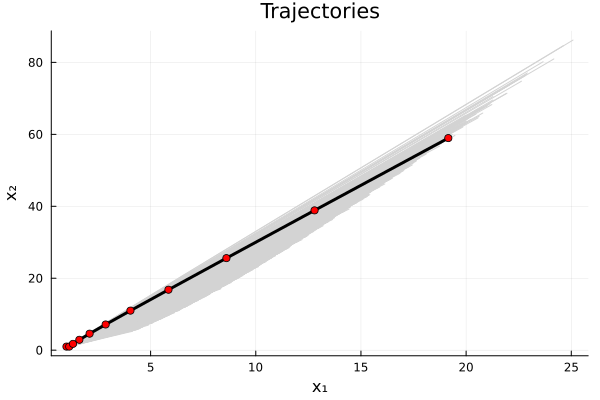

In [38]:
traj_plot = plot(title="Trajectories", xlabel="x₁", ylabel="x₂")
for trajectory in all_trajectories
    x = [point[1] for point in trajectory]
    y = [point[2] for point in trajectory]
    
    plot!(x, y,  label="", linecolor=:lightgray, linewidth=1)
end
x_z = [point[1] for point in z_ideal]
y_z = [point[2] for point in z_ideal]
plot!(x_z, y_z, marker=:circle, label="", linecolor=:black, linewidth=3,  markercolor=:red, markersize=4)
display(traj_plot)